# Imports

In [324]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from upos import upos
from scipy.stats import chi2_contingency, chi2, chisquare

# Constants + Helper Functions

In [325]:
CONJUNCTION_COLORS = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

CONJUNCTION_COLORS = {
    "and": "#9B5DE5",
    "or": "#00BBF9",
    "but": "#38b000",
    "nor": "#d90429",
}

LIKE_UNLIKE_COLORS = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

CATEGORY_COLORS = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

CONJUNCTIONS = ['and', 'or', 'but'] #, 'nor']

CATEGORIES = [upos.NOUN, upos.VERB, upos.ADJ, upos.ADV]

In [326]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [327]:
def get_wordnet_dfs(df):
    '''
    Get five DataFrames for each WordNet relation (synonymy, antonymy,
    hypernymy, co-hyponymy, entailment) using examples from the given
    input df.

    @param df (DataFrame): input of raw coordination samples
    @return (5-tuple of DataFrames): tuple containing a DataFrame for each
        WordNet relation (synonymy_df, antonymy_df, hypernymy_df,
        cohyponymy_df, entailment_df)
    '''
    
    # Get like coordinations
    likes = utils.likes_df(df)

    # Filter out gaps
    likes = likes[(likes['1st Conjunct Lemma'] != "GAP") & (
        likes['2nd Conjunct Lemma'] != "GAP")]

    # Finding closures over wordnet relations produces redundant search warnings
    # We'll just filter these warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Get wordnet relations for like coordinations
        synonymy_df = utils.analyze_synonymy(likes)
        antonymy_df = utils.analyze_antonymy(likes)
        hypernymy_df = utils.analyze_hypernymy(likes)
        cohyponymy_df = utils.analyze_cohyponymy(likes)
        entailment_df = utils.analyze_entailment(likes)

    return (synonymy_df, antonymy_df, hypernymy_df, cohyponymy_df, entailment_df)

### Chi-square Test for Goodness of Fit

In [328]:
def chi2_goodness_of_fit(observed):
    print("Chi-square Test for Goodness of Fit\n")

    N = sum(observed)
    expected = [N / len(observed)] * len(observed)
    stat, p = chisquare(f_obs=observed, f_exp=expected)

    prob = 0.95
    alpha = 1.0 - prob

    print('Observed:', observed)
    print('Expected:', expected)
    print('N={}'.format(N))
    print('Degrees of Freedom = %d' % (len(observed) - 1))

    # interpret p-value
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    print()

### Chi-square Test of Association
Adapted from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

In [329]:
def chi2_association_test(table):
    print("Chi-square Test of Association\n")

    N = sum([sum(l) for l in table])
    stat, p, dof, expected = chi2_contingency(table)
    
    print('Observed:', table)
    print('Expected:', expected)
    print('N={}'.format(N))
    print('Degrees of Freedom = %d' % dof)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' %
          (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    print()


def chi2_by_conjunction(relation_df, freq_func, conjunctions=CONJUNCTIONS):

    group1_freqs = []
    group2_freqs = []

    for conjunction in conjunctions:

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_association_test([group1_freqs, group2_freqs])


def chi2_by_category(relation_df, freq_func, categories=CATEGORIES):

    group1_freqs = []
    group2_freqs = []

    for category in categories:

        df = relation_df.copy()
        df = df.loc[(df['1st Conjunct Category'] == category) &
                    (df['2nd Conjunct Category'] == category)]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_association_test([group1_freqs, group2_freqs])

### Plotting Distributions on Single-Bar Charts

In [330]:
def plot_single_bar(labels, freqs, title, outfile, colors, ylabel='Percentage (%)'):

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars
    freqs = [f * 100 for f in freqs]

    _, ax = plt.subplots()
    rects1 = ax.bar(x, freqs, width, color=colors)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')

In [331]:
def distribution_by_conjunction(relation_df, freq_func, relation_title, outfile,
    conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs = []

    for conjunction in conjunctions:

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freqs.append(freq_func(df))

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CONJUNCTION_COLORS.values())

In [332]:
def distribution_by_category(relation_df, freq_func, relation_title, outfile,
    categories=CATEGORIES, source=None):

    labels = []
    freqs = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        labels.append('Nominal')
        freqs.append(freq_func(nouns))

    if upos.VERB in categories:
        labels.append('Verbal')
        freqs.append(freq_func(verbs))

    if upos.ADJ in categories:
        labels.append('Adjectival')
        freqs.append(freq_func(adjps))

    if upos.ADV in categories:
        labels.append('Adverbial')
        freqs.append(freq_func(advps))

    title = 'Percentages of Coordinations with {}\nby Syntactic Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CATEGORY_COLORS.values())

### Plotting Distributions for Double-Bar Charts

In [333]:
def plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile):

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    freqs1 = [f * 100 for f in freqs1]
    freqs2 = [f * 100 for f in freqs2]

    _, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, freqs1, width,
                    label=sublabels[0])
    rects2 = ax.bar(x + width/2, freqs2, width,
                    label=sublabels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.savefig(outfile, bbox_inches='tight')

In [334]:
def double_distribution_by_conjunction(relation_df, freq_func, relation_title,
    sublabels, outfile, conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    for conjunction in conjunctions:

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freq1, freq2 = freq_func(df)
        freqs1.append(freq1)
        freqs2.append(freq2)

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

In [335]:
def double_distribution_by_category(relation_df, freq_func, relation_title,
    sublabels, outfile, categories=CATEGORIES, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        labels.append('Nominal')
        freq1, freq2 = freq_func(nouns)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.VERB in categories:
        labels.append('Verbal')
        freq1, freq2 = freq_func(verbs)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADJ in categories:
        labels.append('Adjectival')
        freq1, freq2 = freq_func(adjps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADV in categories:
        labels.append('Adverbial')
        freq1, freq2 = freq_func(advps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    title = 'Percentages of Coordinations with {}\nby Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

# Load Data and Get WordNet Relations

In [336]:
# GUM
gum_samples = get_df_from_path('csv/GUM/*.csv')
gum_synonymy_df, gum_antonymy_df, gum_hypernymy_df, gum_cohyponymy_df, gum_entailment_df \
    = get_wordnet_dfs(gum_samples)

# EWT
ewt_samples = get_df_from_path('csv/EWT/*.csv')
ewt_synonymy_df, ewt_antonymy_df, ewt_hypernymy_df, ewt_cohyponymy_df, ewt_entailment_df \
    = get_wordnet_dfs(ewt_samples)

# PUD
pud_samples = get_df_from_path('csv/PUD/*.csv')
pud_synonymy_df, pud_antonymy_df, pud_hypernymy_df, pud_cohyponymy_df, pud_entailment_df \
    = get_wordnet_dfs(pud_samples)

# All sources
all_samples = utils.likes_df(pd.concat([gum_samples, ewt_samples, pud_samples]))
all_synonymy_df = pd.concat(
    [gum_synonymy_df, ewt_synonymy_df, pud_synonymy_df], axis=0, ignore_index=True)
all_antonymy_df = pd.concat(
    [gum_antonymy_df, ewt_antonymy_df, pud_antonymy_df], axis=0, ignore_index=True)
all_hypernymy_df = pd.concat(
    [gum_hypernymy_df, ewt_hypernymy_df, pud_hypernymy_df], axis=0, ignore_index=True)
all_cohyponymy_df = pd.concat(
    [gum_cohyponymy_df, ewt_cohyponymy_df, pud_cohyponymy_df], axis=0, ignore_index=True)
all_entailment_df = pd.concat(
    [gum_entailment_df, ewt_entailment_df, pud_entailment_df], axis=0, ignore_index=True)

utils.pretty_print(all_synonymy_df[all_synonymy_df['Synonyms?']], 'rtf/synonyms.rtf')
utils.pretty_print(all_antonymy_df[all_antonymy_df['Antonyms?']], 'rtf/antonyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['1st Conjunct Hypernym?']], 'rtf/1st_hypernyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['2nd Conjunct Hypernym?']], 'rtf/2nd_hypernyms.rtf')
utils.pretty_print(all_cohyponymy_df[all_cohyponymy_df['Co-hyponyms?']], 'rtf/co-hyponyms.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['1st Conjunct Entails 2nd?']], 'rtf/1st_entailments.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['2nd Conjunct Entails 1st?']], 'rtf/2nd_entailments.rtf')

In [366]:
# Print some examples
pd.set_option('display.max_colwidth', None)
#all_antonymy_df[(all_antonymy_df['Antonyms?']) & (all_antonymy_df['1st Conjunct Category'] == 'ADV')]
# all_synonymy_df[(all_synonymy_df['Synonyms?']) & (all_synonymy_df['1st Conjunct Category'] == 'VERB')]
all_samples[(all_samples['Cosine Similarity'] > 0.8) & (all_samples['1st Conjunct Lemma'] != all_samples['2nd Conjunct Lemma'])]

,1st Conjunct Category,1st Conjunct Lemma,1st Conjunct Text,2nd Conjunct Category,2nd Conjunct Lemma,2nd Conjunct Text,Conjunction,Sentence Text,Cosine Similarity,In WordNet?
167,NOUN,daughter,daughters,NOUN,son,son,and,"They have two daughters, Matilda Eve Goode [3] (b. March 2009) and Teddie Eleanor Rose Goode (b. September 2013), and a son, Ralph Goode (b. August 2015).",0.846830,True
299,NOUN,south,south,NOUN,east,east,and,"Take say on Obama, Obama’s national security advisor James Jones former Marine commandant is on record of favoring expansion of NATO to the south and the east, further expansion of NATO, and also making it an intervention force.",0.936225,True
567,NOUN,afternoon,afternoon,NOUN,evening,evening,and,"Monsoon rains with lightning occur regularly from July to September during the late afternoon and evening, occasionally overnight also.",0.808942,True
576,NOUN,east,east,NOUN,west,west,and,"The monsoon occurs in July till mid-August (during July in the south east and south west of the island, wind surfing activity can be arranged).",0.965323,True
1138,NOUN,male,male,NOUN,female,female,and,"Just because you have a male and female, it cannot be guaranteed the two mated.",0.840533,True
1352,NOUN,north,north,NOUN,east,east,and,"According to former Indian army general A S Kalkat, the difficulty for Kumaratunga's government lay in the fact that the LTTE had become a de jure power in the north and east of the island and was running every aspect of civil administration in the areas within its control.",0.943404,True
1353,NOUN,north,north,NOUN,east,east,and,"Under the accord, a new northeastern provincial council was formed and the Indian army was deployed as peacekeepers in the north and east.",0.943404,True
1425,NOUN,mother,mothers,NOUN,daughter,daughters,and,Husbands marry mothers and teen daughters at the same time.,0.870623,True
1426,NOUN,girl,girls,NOUN,boy,boys,and,"Though ''decided'' is probably not the right word, since from the day they were born, these girls and boys were not taught to think for themselves but to blindly follow their leaders.",0.854327,True
1587,NOUN,grandson,grandsons,NOUN,granddaughter,granddaughters,and,So we now have three grandsons and three granddaughters ranging from about 2 years - 4 months down to a few days.,0.839046,True


# Overall Statistics

In [338]:
print('Total like coordination count:', len(all_samples))

all_samples['In WordNet?'] = all_samples.apply(lambda row:
    utils.in_wordnet(row['1st Conjunct Lemma'], row['1st Conjunct Category']) and
    utils.in_wordnet(row['2nd Conjunct Lemma'], row['1st Conjunct Category']),
    axis=1)

print('Like coordinations with conjuncts present in WordNet:', len(all_samples[all_samples['In WordNet?']]))

Total like coordination count: 6892
Like coordinations with conjuncts present in WordNet: 6641


Chi-square Test for Goodness of Fit

Observed: [5579, 723, 572, 18]
Expected: [1723.0, 1723.0, 1723.0, 1723.0]
N=6892
Degrees of Freedom = 3
stat=11666.026, p=0.000
Dependent (reject H0)



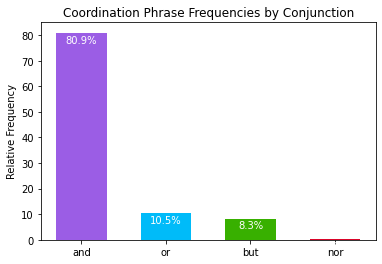

In [339]:
and_count = len(all_samples[all_samples['Conjunction'] == 'and'])
or_count = len(all_samples[all_samples['Conjunction'] == 'or'])
but_count = len(all_samples[all_samples['Conjunction'] == 'but'])
nor_count = len(all_samples[all_samples['Conjunction'] == 'nor'])

conj_counts = [and_count, or_count, but_count, nor_count]
conj_dist = [count / sum(conj_counts) for count in conj_counts]
chi2_goodness_of_fit(conj_counts)
plot_single_bar(['and', 'or', 'but', 'nor'], conj_dist,
'Coordination Phrase Frequencies by Conjunction', 'charts/conjunction_frequencies.pdf',
CONJUNCTION_COLORS.values(), 'Relative Frequency')

In [340]:
first_conjunct_gaps = all_samples[(all_samples['1st Conjunct Lemma'] == "GAP")]
second_conjunct_gaps = all_samples[(all_samples['2nd Conjunct Lemma'] == "GAP")]

print("First conjunct elided:", len(first_conjunct_gaps))
print("Second conjunct elided:", len(second_conjunct_gaps))
first_conjunct_gaps

First conjunct elided: 2
Second conjunct elided: 25


,1st Conjunct Category,1st Conjunct Lemma,1st Conjunct Text,2nd Conjunct Category,2nd Conjunct Lemma,2nd Conjunct Text,Conjunction,Sentence Text,Cosine Similarity,In WordNet?
3850,VERB,GAP,deny,VERB,deny,denied,and,"The evidence of President Trump's abuse of power and attempt to solicit foreign interference in the 2020 elections is clear enough that Republican Senators cannot and have not denied the facts, yet they cannot bring themselves to confront this President and are choosing party over country.",-0.008484,True
4648,VERB,GAP,taken,VERB,take,taken,and,"Various mitigating actions have been and will be taken to provide focus, gain comfort over control levels and to provide assurance to senior management as to the accuracy of the Q1 DPR and business balance sheet.",-0.049169,True


# Synonymy

In [341]:
def get_synonyms_freqs(df, raw=False):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    if raw:
        return (syns_count, tot - syns_count)
        
    return syns_count / tot if tot != 0 else 0

### By Conjunction

Chi-square Test of Association

Observed: [[160, 23, 19], [5209, 651, 542]]
Expected: [[ 164.22440945   20.61599031   17.15960024]
 [5204.77559055  653.38400969  543.84039976]]
N=6604
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=0.600
Independent (fail to reject H0)
significance=0.050, p=0.741
Independent (fail to reject H0)



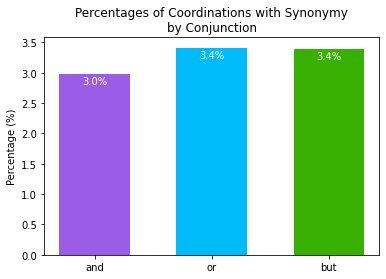

In [342]:
def synonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_conjunction(all_synonymy_df, get_synonyms_freqs)
synonym_conjunction_distribution(all_synonymy_df, 'charts/synonymy_by_conjunction.pdf')
# synonym_conjunction_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_conjunction.pdf', source='GUM')
# synonym_conjunction_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_conjunction.pdf', source='EWT')
# synonym_conjunction_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[40, 147, 14, 2], [2407, 3289, 618, 104]]
Expected: [[7.50250717e+01 1.05347833e+02 1.93771334e+01 3.24996224e+00]
 [2.37197493e+03 3.33065217e+03 6.12622867e+02 1.02750038e+02]]
N=6621
Degrees of Freedom = 3
probability=0.950, critical=7.815, stat=35.893
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



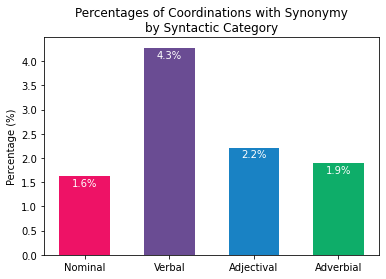

In [343]:
def synonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_category(all_synonymy_df, get_synonyms_freqs)
synonym_category_distribution(all_synonymy_df, 'charts/synonymy_by_category.pdf')
# synonym_category_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_category.pdf', source='GUM')
# synonym_category_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_category.pdf', source='EWT')
# synonym_category_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_category.pdf', source='PUD')

# Antonymy

In [344]:
def get_antonyms_freqs(df, raw=False):
    # Get antonyms
    ants = df.loc[(df['Antonyms?'] == True)]
    ants.reset_index(drop=True, inplace=True)

    # Get counts
    count_ants = len(ants.index)
    tot = len(df.index)

    if raw:
        return (count_ants, tot - count_ants)
    return count_ants / tot if tot != 0 else 0


### By Conjunction

Chi-square Test of Association

Observed: [[38, 16, 1], [576, 53, 53]]
Expected: [[ 45.82089552   5.14925373   4.02985075]
 [568.17910448  63.85074627  49.97014925]]
N=737
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=28.613
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



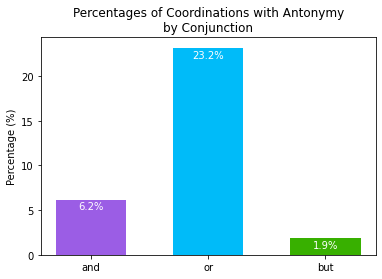

In [345]:
def antonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_antonyms_freqs, "Antonymy", outfile, source=source)

chi2_by_conjunction(all_antonymy_df, get_antonyms_freqs)
antonym_conjunction_distribution(all_antonymy_df, 'charts/antonymy_by_conjunction.pdf')
# antonym_conjunction_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_conjunction.pdf', source='GUM')
# antonym_conjunction_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_conjunction.pdf', source='EWT')
# antonym_conjunction_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[38, 17], [594, 89]]
Expected: [[ 47.100271   7.899729]
 [584.899729  98.100271]]
N=738
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=11.814
Dependent (reject H0)
significance=0.050, p=0.001
Dependent (reject H0)



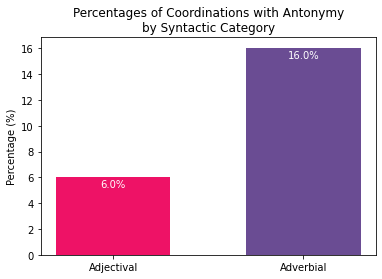

In [346]:
def antonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_antonyms_freqs, "Antonymy",
        outfile, categories=[upos.ADJ, upos.ADV], source=source)

chi2_by_category(all_antonymy_df, get_antonyms_freqs, categories=[upos.ADJ, upos.ADV])
antonym_category_distribution(all_antonymy_df, 'charts/antonymy_by_category.pdf')
# antonym_category_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_category.pdf', source='GUM')
# antonym_category_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_category.pdf', source='EWT')
# antonym_category_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_category.pdf', source='PUD')

# Hypernymy

In [347]:
def get_hypernymy_freqs(df, raw=False):
    tot = len(df.index)
    df = df.loc[(df['1st Conjunct Hypernym?'] == True) | (df['2nd Conjunct Hypernym?'] == True)]
    df = df.loc[(df['1st Conjunct Hypernym?']) != (df['2nd Conjunct Hypernym?'])]

    # Get 1st conjunct hypernymy
    hyps1 = df.loc[(df['1st Conjunct Hypernym?'] == True)]
    hyps1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct hypernymy
    hyps2 = df.loc[(df['2nd Conjunct Hypernym?'] == True)]
    hyps2.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps1 = len(hyps1.index)
    count_hyps2 = len(hyps2.index)
    
    if raw:
        return (count_hyps1, count_hyps2)

    return (count_hyps1 / tot, count_hyps2 / tot) if tot != 0 else (0,0)

In [348]:
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)

Chi-square Test for Goodness of Fit

Observed: [334, 372]
Expected: [353.0, 353.0]
N=706
Degrees of Freedom = 1
stat=2.045, p=0.153
Independent (fail to reject H0)



### By Conjunction

'and'
Chi-square Test for Goodness of Fit

Observed: [260, 293]
Expected: [276.5, 276.5]
N=553
Degrees of Freedom = 1
stat=1.969, p=0.161
Independent (fail to reject H0)


'or'
Chi-square Test for Goodness of Fit

Observed: [35, 48]
Expected: [41.5, 41.5]
N=83
Degrees of Freedom = 1
stat=2.036, p=0.154
Independent (fail to reject H0)


'but'
Chi-square Test for Goodness of Fit

Observed: [39, 30]
Expected: [34.5, 34.5]
N=69
Degrees of Freedom = 1
stat=1.174, p=0.279
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[260, 35, 39], [293, 48, 30]]
Expected: [[261.98865248  39.32198582  32.6893617 ]
 [291.01134752  43.67801418  36.3106383 ]]
N=705
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=3.246
Independent (fail to reject H0)
significance=0.050, p=0.197
Independent (fail to reject H0)



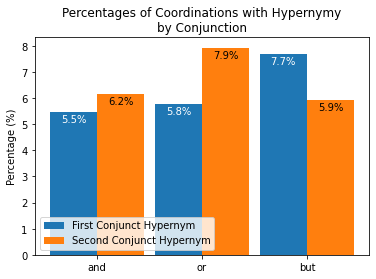

In [349]:
def hypernymy_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_hypernymy_freqs, "Hypernymy",
    ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile, source=source)

print("'and'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'and'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("'or'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'or'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("'but'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'but'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

chi2_by_conjunction(all_hypernymy_df, get_hypernymy_freqs)
hypernymy_conjunction_distribution(all_hypernymy_df, 'charts/hypernymy_by_conjunction.pdf')
# hypernymy_conjunction_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_conjunction.pdf', source='GUM')
# hypernymy_conjunction_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_conjunction.pdf', source='EWT')
# hypernymy_conjunction_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_conjunction.pdf', source='PUD')

### By Category

Nouns
Chi-square Test for Goodness of Fit

Observed: [115, 119]
Expected: [117.0, 117.0]
N=234
Degrees of Freedom = 1
stat=0.068, p=0.794
Independent (fail to reject H0)


Verbs
Chi-square Test for Goodness of Fit

Observed: [219, 253]
Expected: [236.0, 236.0]
N=472
Degrees of Freedom = 1
stat=2.449, p=0.118
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[115, 219], [119, 253]]
Expected: [[110.70254958 223.29745042]
 [123.29745042 248.70254958]]
N=706
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=0.370
Independent (fail to reject H0)
significance=0.050, p=0.543
Independent (fail to reject H0)



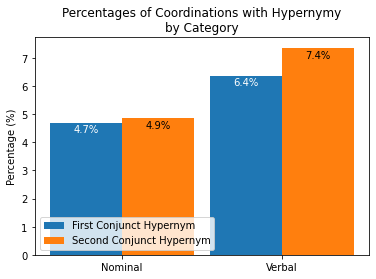

In [350]:
def hypernymy_category_distribution(df, outfile, source=None):
    double_distribution_by_category(df, get_hypernymy_freqs, "Hypernymy",
        ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

nouns, verbs, _, _ = utils.likes_by_category(all_hypernymy_df)

print("Nouns")
hypernymy_freqs = list(get_hypernymy_freqs(nouns, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("Verbs")
hypernymy_freqs = list(get_hypernymy_freqs(verbs, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

chi2_by_category(all_hypernymy_df, get_hypernymy_freqs, categories=[upos.NOUN, upos.VERB])
hypernymy_category_distribution(all_hypernymy_df, 'charts/hypernymy_by_category.pdf')
# hypernymy_category_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_category.pdf', source='GUM')
# hypernymy_category_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_category.pdf', source='EWT')
# hypernymy_category_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_category.pdf', source='PUD')

# Co-Hyponymy

In [351]:
def get_cohyponyms_freqs(df, raw=False):
    # Get co-hyponymy
    hyps = df.loc[(df['Co-hyponyms?'] == True)]
    hyps.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps = len(hyps.index)
    tot = len(df.index)

    if raw:
        return (count_hyps, tot - count_hyps)
        
    return count_hyps / tot if tot != 0 else 0

### By Conjunction

Chi-square Test of Association

Observed: [[836, 104, 94], [3919, 501, 413]]
Expected: [[ 838.02113516  106.62519175   89.35367309]
 [3916.97886484  498.37480825  417.64632691]]
N=5867
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=0.378
Independent (fail to reject H0)
significance=0.050, p=0.828
Independent (fail to reject H0)



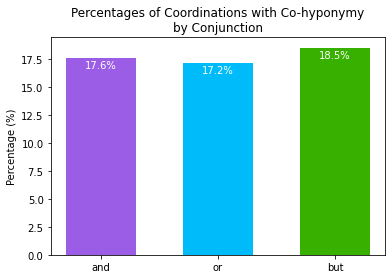

In [352]:
def cohyponymy_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_cohyponyms_freqs, "Co-hyponymy", outfile, source=source)

chi2_by_conjunction(all_cohyponymy_df, get_cohyponyms_freqs)
cohyponymy_conjunction_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_conjunction.pdf')
# cohyponymy_conjunction_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_conjunction.pdf', source='GUM')
# cohyponymy_conjunction_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_conjunction.pdf', source='EWT')
# cohyponymy_conjunction_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[285, 750], [2162, 2686]]
Expected: [[ 430.50229475  604.49770525]
 [2016.49770525 2831.50229475]]
N=5883
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=101.474
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



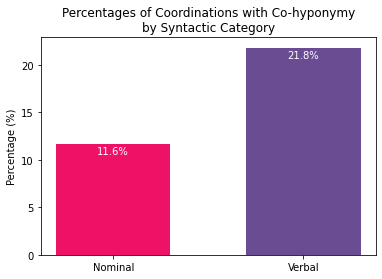

In [353]:
def cohyponymy_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_cohyponyms_freqs, "Co-hyponymy", outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

chi2_by_category(all_cohyponymy_df, get_cohyponyms_freqs, categories=[upos.NOUN, upos.VERB])
cohyponymy_category_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_category.pdf')
# cohyponymy_category_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_category.pdf', source='GUM')
# cohyponymy_category_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_category.pdf', source='EWT')
# cohyponymy_category_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_category.pdf', source='PUD')

# Entailment

In [354]:
def get_entailment_freqs(df, raw=False):
    tot = len(df.index)
    
    df = df.loc[(df['1st Conjunct Entails 2nd?'] == True) | (df['2nd Conjunct Entails 1st?'] == True)]
    df = df.loc[(df['1st Conjunct Entails 2nd?']) != (df['2nd Conjunct Entails 1st?'])]

    # Get 1st conjunct entailment
    entl1 = df.loc[(df['1st Conjunct Entails 2nd?'] == True)]
    entl1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct entailment
    entl2 = df.loc[(df['2nd Conjunct Entails 1st?'] == True)]
    entl2.reset_index(drop=True, inplace=True)

    # Get counts
    count_entl1 = len(entl1.index)
    count_entl2 = len(entl2.index)
    
    if raw:
        return (count_entl1, count_entl2)

    return (count_entl1 / tot, count_entl2 / tot) if tot != 0 else (0,0)

In [355]:
entailment_freqs = list(get_entailment_freqs(all_entailment_df, raw=True))
chi2_goodness_of_fit(entailment_freqs)

Chi-square Test for Goodness of Fit

Observed: [10, 17]
Expected: [13.5, 13.5]
N=27
Degrees of Freedom = 1
stat=1.815, p=0.178
Independent (fail to reject H0)



# By Conjunction

'and'
Chi-square Test for Goodness of Fit

Observed: [7, 15]
Expected: [11.0, 11.0]
N=22
Degrees of Freedom = 1
stat=2.909, p=0.088
Independent (fail to reject H0)


'or'
Chi-square Test for Goodness of Fit

Observed: [0, 1]
Expected: [0.5, 0.5]
N=1
Degrees of Freedom = 1
stat=1.000, p=0.317
Independent (fail to reject H0)


'but'
Chi-square Test for Goodness of Fit

Observed: [3, 1]
Expected: [2.0, 2.0]
N=4
Degrees of Freedom = 1
stat=1.000, p=0.317
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[7, 0, 3], [15, 1, 1]]
Expected: [[ 8.14814815  0.37037037  1.48148148]
 [13.85185185  0.62962963  2.51851852]]
N=27
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=3.317
Independent (fail to reject H0)
significance=0.050, p=0.190
Independent (fail to reject H0)



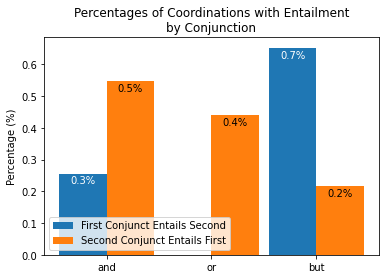

In [356]:
def entailment_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_entailment_freqs, "Entailment",
        ('First Conjunct Entails Second', 'Second Conjunct Entails First'), outfile,
        source=source)

print("'and'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'and'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

print("'or'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'or'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

print("'but'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'but'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

chi2_by_conjunction(all_entailment_df, get_entailment_freqs)
entailment_conjunction_distribution(all_entailment_df, 'charts/entailment_by_conjunction.pdf')
# entailment_conjunction_distribution(gum_entailment_df, 'charts/GUM_entailment_by_conjunction.pdf', source='GUM')
# entailment_conjunction_distribution(ewt_entailment_df, 'charts/EWT_entailment_by_conjunction.pdf', source='EWT')
# entailment_conjunction_distribution(pud_entailment_df, 'charts/PUD_entailment_by_conjunction.pdf', source='PUD')

## Comparison Across WordNet Relations

In [357]:
print('Synonym count', len(all_synonymy_df[all_synonymy_df['Synonyms?']]))
print('Antonym count', len(all_antonymy_df[all_antonymy_df['Antonyms?']]))
print('Hypernym count', len(
    all_hypernymy_df[all_hypernymy_df['1st Conjunct Hypernym?'] | all_hypernymy_df['2nd Conjunct Hypernym?']]))
print('Co-hyponym count',
      len(all_cohyponymy_df[all_cohyponymy_df['Co-hyponyms?']]))

chi2_goodness_of_fit([len(all_synonymy_df[all_synonymy_df['Synonyms?']]),
                      len(all_antonymy_df[all_antonymy_df['Antonyms?']]),
                      len(all_hypernymy_df[all_hypernymy_df['1st Conjunct Hypernym?']
                          | all_hypernymy_df['2nd Conjunct Hypernym?']]),
                      len(all_cohyponymy_df[all_cohyponymy_df['Co-hyponyms?']])])


Synonym count 203
Antonym count 55
Hypernym count 783
Co-hyponym count 1035
Chi-square Test for Goodness of Fit

Observed: [203, 55, 783, 1035]
Expected: [519.0, 519.0, 519.0, 519.0]
N=2076
Degrees of Freedom = 3
stat=1254.536, p=0.000
Dependent (reject H0)



# Word2Vec Cosine Similarity

and
mean: 0.258324952825245
std: 0.15700038114061854
count: 5334
min: -0.1561391502618789
max: 0.9674535393714904
sterr: 0.002169084682544582
or
mean: 0.2892060893607464
std: 0.1800219566242847
count: 670
min: -0.0690941661596298
max: 0.964065670967102
sterr: 0.007044803550858797
but
mean: 0.24640087474041225
std: 0.14177724399408162
count: 530
min: -0.0731841772794723
max: 0.7344212532043457
sterr: 0.006187666213572403


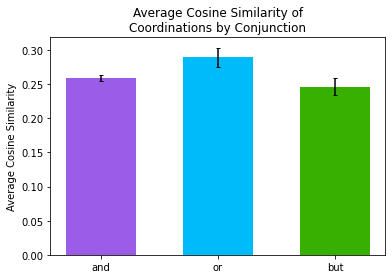

In [358]:
labels = []
freqs = []
vars = []

for conjunction in CONJUNCTIONS:
    print(conjunction)
    
    labels.append(conjunction)
    
    df = all_samples.copy()
    df = df.loc[df['1st Conjunct Lemma'] != df['2nd Conjunct Lemma']]
    df = df.loc[df['Conjunction'] == conjunction]

    print('mean:', str(df['Cosine Similarity'].mean()))
    print('std:', str(df['Cosine Similarity'].std()))
    print('count:', str(len(df)))
    print('min:', str(df['Cosine Similarity'].min()))
    print('max:', str(df['Cosine Similarity'].max()))
    print('sterr:', str(df['Cosine Similarity'].sem()))
 
    freqs.append(df['Cosine Similarity'].mean())
    vars.append(df['Cosine Similarity'].sem())

sems = []
for v in vars:
    sems.append(v * 2)

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x, freqs, width, label='Likes', capsize=2, color=CONJUNCTION_COLORS.values(), yerr=sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of\nCoordinations by Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('charts/cossim_conjunction.pdf', bbox_inches='tight')

NOUN
mean: 0.2659104031044595
std: 0.17819211887400754
count: 2474
min: -0.1561391502618789
max: 0.9653225541114808
sterr: 0.0036365738545715825
VERB
mean: 0.2417463405443423
std: 0.13175710914437813
count: 3331
min: -0.103547379374504
max: 0.7639904618263245
sterr: 0.00229290215794319
ADJ
mean: 0.30879573550140776
std: 0.16599125859335262
count: 646
min: -0.0746884644031524
max: 0.8928130269050598
sterr: 0.006602777744171946
ADV
mean: 0.4432998561121599
std: 0.22359839005835683
count: 100
min: -0.0353934355080127
max: 0.9674535393714904
sterr: 0.02247248374397281


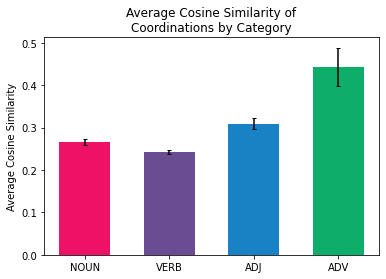

In [359]:
labels = []
freqs = []
vars = []

for category in CATEGORIES:
    print(category)
    
    labels.append(category)
    
    df = all_samples.copy()
    df = df[df['1st Conjunct Lemma'] != df['2nd Conjunct Lemma']]
    df = df.loc[df['1st Conjunct Category'] == category]
    df = df.loc[df['2nd Conjunct Category'] == category]

    print('mean:', str(df['Cosine Similarity'].mean()))
    print('std:', str(df['Cosine Similarity'].std()))
    print('count:', str(len(df)))
    print('min:', str(df['Cosine Similarity'].min()))
    print('max:', str(df['Cosine Similarity'].max()))
    print('sterr:', str(df['Cosine Similarity'].sem()))
 
    freqs.append(df['Cosine Similarity'].mean())
    vars.append(df['Cosine Similarity'].sem())

sems = []
for v in vars:
    sems.append(2 * v)

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x, freqs, width, label='Likes', capsize=2, color=CATEGORY_COLORS.values(), yerr=sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of\nCoordinations by Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('charts/cossim_category.pdf', bbox_inches='tight')